<a href="https://colab.research.google.com/github/RubenCrack/MasterIA_AprendizajeProfundo/blob/main/Evaluacion_Modulo_IA_RubenGarcia_Red_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)

## Evaluación de módulos I y II 
### Modelo CNN
**Alumno :**

- Rubén Alejandro García Zegarra
---------------------------------------------------

In [1]:
#Variable de control para descarga del Dataset
COLAB = True

Definición de librerias:


In [2]:
#Declarando librerias
from google.colab import drive
from glob import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras import backend as K

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [3]:
#Descarga del Dataset
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1el30soqoJ_OGiOwCki6g4Loez9r8aBBQ',
                                        dest_path='./DataSet.zip', unzip=True)

Unzipping...Done.


In [4]:
#Listando directorios
!ls

DataSet.zip  DataTest  DataTrain  DataVal  sample_data


###Pasos para separar data en Train y Validación 

In [5]:
#Cargando archivos de cada carpeta en arrays
ficheros_train = glob("./DataTrain/coast/*jpg")
ficheros_val = glob("./DataVal/forest/*jpg")
ficheros_test = glob("./DataTest/highway/*jpg")

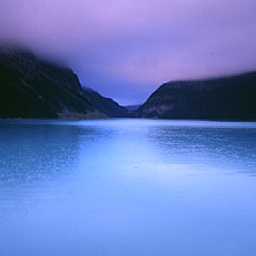

(256, 256, 3) 



In [6]:
##Mostrando imagen de ejemplo
imagen = load_img(ficheros_train[1])
#Verifica tamaño de la imagen
display(imagen)
print(np.array(imagen).shape, "\n")

In [7]:
#Prepara carpetas
train_data_dir      = 'DataTrain'
validation_data_dir = 'DataVal'
test_data_dir       = 'DataTest'

####Red convolucional

In [8]:
# dimensiones a las que vamos a llevar las imágenes: 150 x 150
img_width, img_height = 150, 150
normed_dims = (img_height, img_width)
normed_dims

(150, 150)

In [9]:
#Definir tamaño del batch size
batch_size = 16

In [10]:
# Definir arquitextura del modelo:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
#--- aqui empieza la red neuronal 'standard'  ---
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8))  #8 neuronas de salida, una por cada clase
model.add(Activation("softmax")) # Separamos la función de activación del dense para el cálculo posterior de los heatmaps

# cálculo posterior de los heatmaps
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.RMSprop(), metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

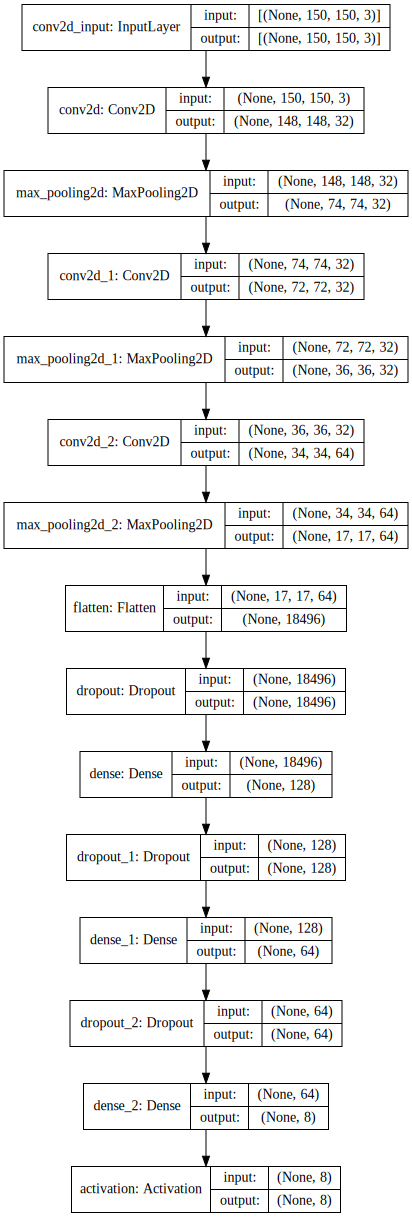

In [12]:
#Mostrar graficamente el Summary
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))

####Opciones para Data Aumentation:

In [13]:
#Preparando parámetros para Data aumentation
preprocess_input = lambda x:x/255.

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

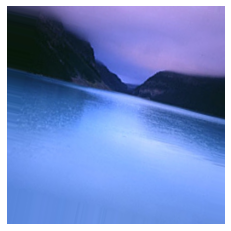

In [14]:
#Muestra imagen de ejemplo
imagen_num1 = np.expand_dims(np.array(imagen), axis=0)
plt.imshow(train_datagen.flow(imagen_num1)[0][0])
plt.axis("off");

####Entrenamos la red

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

Found 1882 images belonging to 8 classes.
Found 565 images belonging to 8 classes.
Found 241 images belonging to 8 classes.


In [16]:
#Verificacion de indices
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


In [17]:
#Obteniendo el numero de muestras por cada set de datos
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n
print(number_train_samples, number_val_samples, number_test_samples)

1882 565 241


In [18]:
#Declara función para mostrar gráficamente el entreanmiento
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [19]:
#Definir arrays para calculos
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

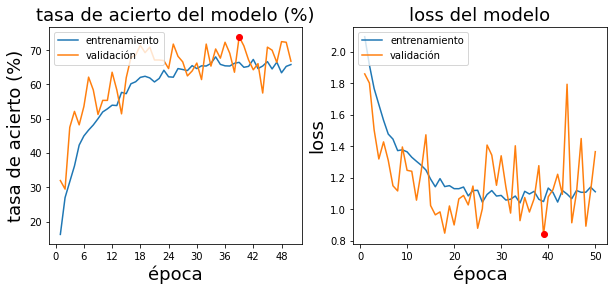

In [20]:
#Entrenar modelo
epochs = 50

modelpath="best_model_1.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    print("Loop Number: ",e)
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                        )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [21]:
#Verificamos archivo H5
!ls -la

total 141660
drwxr-xr-x  1 root root      4096 Mar 23 21:32 .
drwxr-xr-x  1 root root      4096 Mar 23 21:29 ..
-rw-r--r--  1 root root  19301984 Mar 23 21:41 best_model_1.h5
drwxr-xr-x  4 root root      4096 Mar 18 13:36 .config
-rw-r--r--  1 root root 125721697 Mar 23 21:30 DataSet.zip
drwxr-xr-x 10 root root      4096 Mar 23 21:30 DataTest
drwxr-xr-x 10 root root      4096 Mar 23 21:30 DataTrain
drwxr-xr-x 10 root root      4096 Mar 23 21:30 DataVal
drwxr-xr-x  1 root root      4096 Mar 18 13:36 sample_data


In [22]:
#Guardamos archivo H5
model = load_model(modelpath)
model

## **Resultados obtenidos**

In [23]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

118/118 [==============================] - 12s 98ms/step - loss: 0.9131 - accuracy: 0.7072
Train loss    : 0.9130503535270691
Train accuracy: 0.7072263360023499

36/36 [==============================] - 1s 33ms/step - loss: 0.8439 - accuracy: 0.7363
Val loss    : 0.8439106345176697
Val accuracy: 0.7362831830978394

16/16 [==============================] - 1s 36ms/step - loss: 1.0210 - accuracy: 0.7261
Test loss     : 1.0210366249084473
Test accuracy : 0.726141095161438


In [24]:
#Reporte de clasificacion
y_real = test_generator.classes
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.91      0.83        32
           1       0.81      0.59      0.68        29
           2       0.50      0.17      0.26        23
           3       0.85      0.82      0.84        28
           4       0.67      0.82      0.74        34
           5       0.60      0.81      0.69        37
           6       0.74      0.65      0.69        26
           7       0.84      0.84      0.84        32

    accuracy                           0.73       241
   macro avg       0.72      0.70      0.70       241
weighted avg       0.72      0.73      0.71       241



In [50]:
#Matriz de confusión
#print('Confusion Matrix')
#print(confusion_matrix(test_generator.classes, y_pred))
import itertools

cm = confusion_matrix(test_generator.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
  
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

Confusion matrix, without normalization


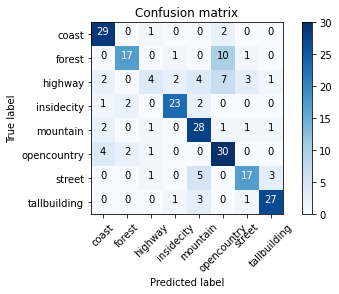

In [51]:
plot_confusion_matrix(cm=cm,classes=['coast','forest','highway','insidecity','mountain','opencountry','street','tallbuilding'],normalize=False)

In [52]:
#Verifica clases del Test
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'coast',
 1: 'forest',
 2: 'highway',
 3: 'insidecity',
 4: 'mountain',
 5: 'opencountry',
 6: 'street',
 7: 'tallbuilding'}

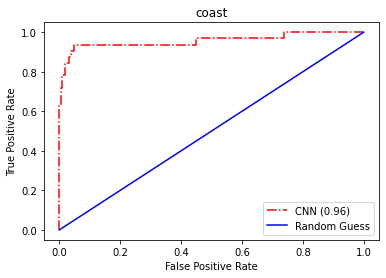

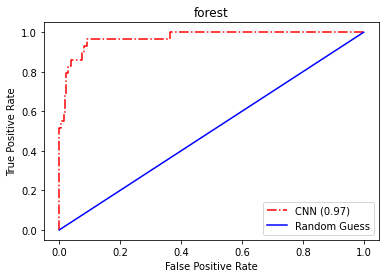

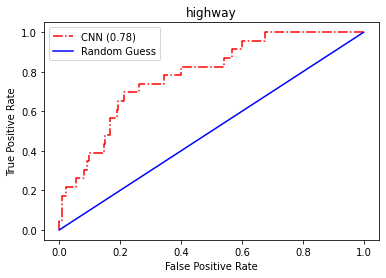

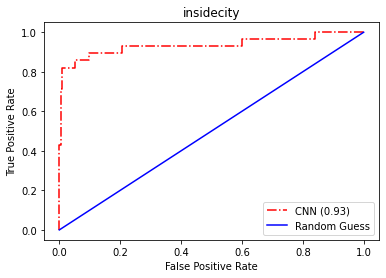

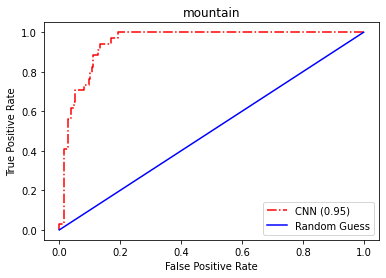

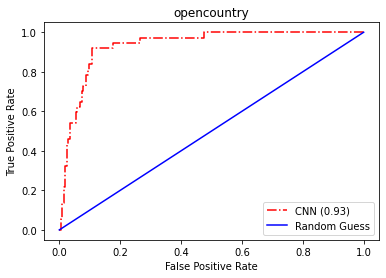

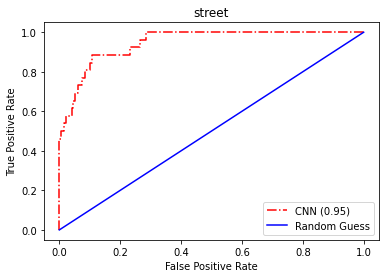

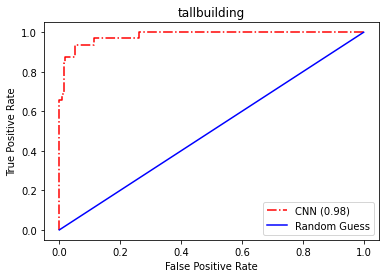

In [53]:
#Curva Roc
for clase in range(8):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

## **Visualización de ejemplos de test**

In [54]:
#Preparación de generador de Test
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágenes del directorio test
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

Found 241 images belonging to 8 classes.


In [55]:
#Generar variables a predecir
test_generator2.reset()
X_te, y_te = test_generator2.next()
print(X_te.shape,y_te.shape)

(241, 150, 150, 3) (241,)


In [56]:
#Guarda clases
class_indices = test_generator2.class_indices
num3class = {test_generator2.class_indices[x]:x  for x in test_generator2.class_indices.keys()}

####Prueba de predicción: Ingresar un número de imágen entre 1 y 241

Introduce un numero entre 1 y 241, luego presione ENTER : 68
--------------------------------------------------------

Clase real: highway
-------------------------
Probabilidad: highway 37.09%              Probabilidad: opencountry 19.06%       
Probabilidad: mountain 18.66%             Probabilidad: coast 13.85%             
Probabilidad: street 5.27%                Probabilidad: insidecity 2.48%         
Probabilidad: tallbuilding 1.82%          Probabilidad: forest 1.78%             


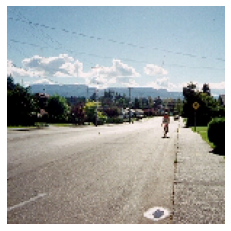

In [57]:
numero_img = int(input("Introduce un numero entre 1 y 241, luego presione ENTER : "))
print("--------------------------------------------------------")
print("")
if (numero_img<1 or numero_img>241):
  print("¡ El numero ingreso es inválido !")

#Ejemplo
ind_te1 = numero_img
image = X_te[ind_te1].copy()
print("Clase real:", num3class[y_te[ind_te1]])
plt.imshow(image, cmap='jet')
plt.axis("off")

print("-------------------------")

lista1=[]

j=0
for i in num3class.keys():
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices[num3class.get(i)]]
  linea_imprimir = "Probabilidad: " + num3class.get(i) + " {:2.2f}%".format(100*p)
  lista1.append([])
  #numfor=format(100*p, '2.1f'):.2%
  lista1[j].append(100*p)
  lista1[j].append(linea_imprimir)
  j=j+1

lista2=sorted(lista1, reverse=True)

k=0
for i in range(4):
  print(lista2[k][1].ljust(39) + "   " + lista2[k+1][1].ljust(39)) # + "   " + lista2[k+2][1].ljust(39))
  k=k+2

## **Visualización de mapas de sensibilidades (heatmaps) :**

In [58]:
#Definición de funciones
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]
   
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    return heatmap, superimposed_img

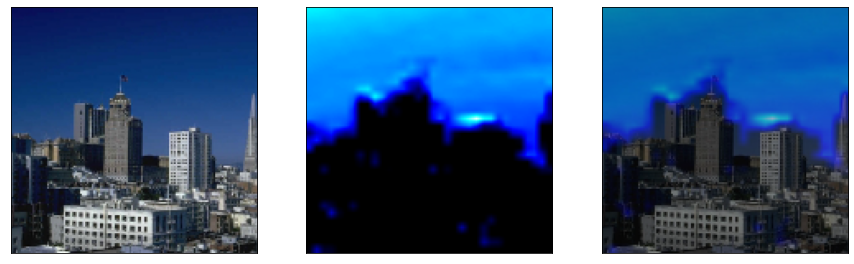

---------------------------------------------------------------------------------------------------


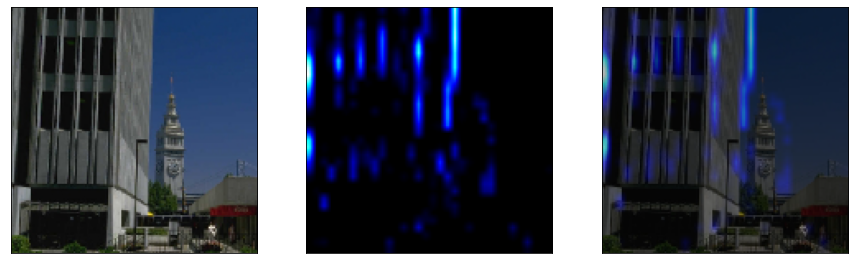

---------------------------------------------------------------------------------------------------


In [90]:
#Visualizamos ejemplos de test a partir de este número de imagen
ind = 210
for i in range(ind, ind+2):
    show_heatmap(model, X_te[i])
    print("---------------------------------------------------------------------------------------------------")

In [91]:
# Para descargar el modelo a local:
from google.colab import files
files.download(modelpath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>